In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing libraries

In [4]:
import os
import cv2 as cv
import numpy as np
left_image = cv.imread('/content/drive/MyDrive/stereo/left2.png')
right_image = cv.imread('/content/drive/MyDrive/stereo/right2.png')


In [5]:
a=np.array(left_image)
print(a.shape)

(375, 450, 3)


Displaying of input and output images

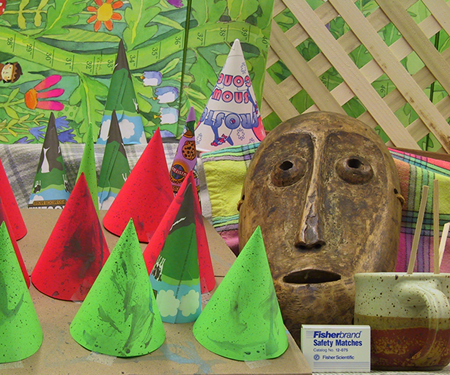

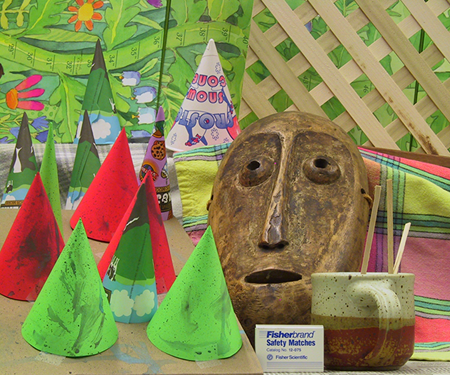

In [6]:
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
cv2_imshow(left_image)
cv2_imshow(right_image)

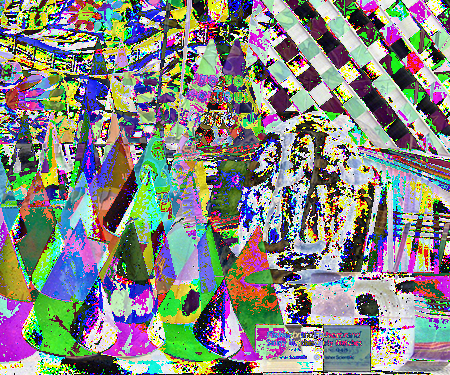

In [7]:
cv2_imshow(left_image-right_image)

Taking inputs of distance ,method ,search range,template_size

In [10]:
levels = int(input('Enter number of levels: '))
if not levels > 0:
	raise Exception('levels must be greater than 0. Input levels:{}'.format(levels))


distance = []
method = []
search_range = []
template_size_x = []
template_size_y = []

for i in range(levels):
	print('------------------------------------------')
	distance.append(input('Enter {}th level distance [SAD, SSD, NCC]:'.format(i)))
	method.append(input('Enter {}th level method [region, feature]:'.format(i)))
	search_range.append(int(input('Enter {}th level search range (need to be integer):'.format(i))))
	template_size_x.append(int(input('Enter {}th level template_x_size (need to be odd integer):'.format(i))))
	template_size_y.append(int(input('Enter {}th level template_y_size (need to be odd integer):'.format(i))))

Enter number of levels: 1
------------------------------------------
Enter 0th level distance [SAD, SSD, NCC]:1
Enter 0th level method [region, feature]:1
Enter 0th level search range (need to be integer):2
Enter 0th level template_x_size (need to be odd integer):7
Enter 0th level template_y_size (need to be odd integer):7


Sum of absolute difference function implementation :

In [11]:
import numpy as np
import cv2
from numpy.lib.stride_tricks import as_strided


def sumOfAbsDiff(image, template, mask=None):
    if mask is None:
        mask = np.ones_like(template)
    window_size = template.shape

    updatedImage = as_strided(image, shape=(image.shape[0] - window_size[0] + 1, image.shape[1] - window_size[1] + 1,) +
                                           window_size, strides=image.strides * 2)

    # Compute the sum of squared differences
    ssd = ((abs(updatedImage - template)) * mask).sum(axis=-1).sum(axis=-1)
    return ssd


def disparity_sad(left, right, templateSize, window, lambdaValue):
    im_rows, im_cols = left.shape
    tpl_rows = tpl_cols = templateSize
    disparity = np.zeros(left.shape, dtype=np.float32)


    for r in range(tpl_rows//2, im_rows-tpl_rows//2):
        tr_min, tr_max = max(r-tpl_rows//2, 0), min(r+tpl_rows//2+1, im_rows)
        for c in range(tpl_cols//2, im_cols-tpl_cols//2):
            tc_min = max(c-tpl_cols//2, 0)
            tc_max = min(c+tpl_cols//2+1, im_cols)
            tpl = left[tr_min:tr_max, tc_min:tc_max].astype(np.float32)
            rc_min = max(c - window // 2, 0)
            rc_max = min(c + window // 2 + 1, im_cols)
            R_strip = right[tr_min:tr_max, rc_min:rc_max].astype(np.float32)
            error = sumOfAbsDiff(R_strip, tpl)
            c_tf = max(c-rc_min-tpl_cols//2, 0)
            dist = np.arange(error.shape[1]) - c_tf
            cost = error + np.abs(dist * lambdaValue)
            _,_,min_loc,_ = cv2.minMaxLoc(cost)
            disparity[r, c] = dist[min_loc[0]]
    return disparity

Sum of square difference function implementation :

In [12]:
import numpy as np
import cv2
from numpy.lib.stride_tricks import as_strided


def sumOfSquaredDiff(image, template, mask=None):
    if mask is None:
        mask = np.ones_like(template)
    window_size = template.shape

    updatedImage = as_strided(image, shape=(image.shape[0] - window_size[0] + 1, image.shape[1] - window_size[1] + 1,) +
                                           window_size, strides=image.strides * 2)

    # Compute the sum of squared differences
    ssd = ((updatedImage - template) ** 2 * mask).sum(axis=-1).sum(axis=-1)
    return ssd


def disparity_ssd(left, right, templateSize, window, lambdaValue):
    im_rows, im_cols = left.shape
    tpl_rows = tpl_cols = templateSize
    disparity = np.zeros(left.shape, dtype=np.float32)

    for r in range(int(tpl_rows//2), int(im_rows-tpl_rows//2)):
        tr_min, tr_max = max(r-tpl_rows//2, 0), min(r+tpl_rows//2+1, im_rows)
        for c in range(int(tpl_cols//2), int(im_cols-tpl_cols//2)):
            tc_min = max(c-tpl_cols//2, 0)
            tc_max = min(c+tpl_cols//2+1, im_cols)
            tpl = left[tr_min:tr_max, tc_min:tc_max].astype(np.float32)
            rc_min = max(c - window // 2, 0)
            rc_max = min(c + window // 2 + 1, im_cols)
            R_strip = right[tr_min:tr_max, rc_min:rc_max].astype(np.float32)
            error = sumOfSquaredDiff(R_strip, tpl)
            c_tf = max(c-rc_min-tpl_cols//2, 0)
            dist = np.arange(error.shape[1]) - c_tf
            cost = error + np.abs(dist * lambdaValue)
            _,_,min_loc,_ = cv2.minMaxLoc(cost)
            disparity[r, c] = dist[min_loc[0]]
    return disparity

Normalized correlation function implementation :

In [13]:
import numpy as np
import cv2


def disparity_ncorr(left, right, templateSize, window, lambdaValue):
    im_rows, im_cols = left.shape
    print(left.shape)
    tpl_rows = tpl_cols = templateSize
    print(left.shape)
    disparity = np.zeros(left.shape, dtype=np.float32)

    for r in range(int(tpl_rows/2), int(im_rows-tpl_rows/2)):
        tr_min, tr_max = max(int(r-tpl_rows/2), 0), min(int(r+tpl_rows/2+1), im_rows)
        for c in range(int(tpl_cols//2), int(im_cols-tpl_cols//2)):
            tc_min = max(c-tpl_cols//2, 0)
            tc_max = min(c+tpl_cols//2+1, im_cols)
            tpl = left[tr_min:tr_max, tc_min:tc_max].astype(np.float32)
            rc_min = max(c - window // 2, 0)
            rc_max = min(c + window // 2 + 1, im_cols)
            R_strip = right[tr_min:tr_max, rc_min:rc_max].astype(np.float32)
            error = cv2.matchTemplate(R_strip, tpl, method=cv2.TM_CCORR_NORMED)
            c_tf = max(c-rc_min-tpl_cols//2, 0)
            dist = np.arange(error.shape[1]) - c_tf
            cost = error - np.abs(dist * lambdaValue)
            _,_,_,max_loc = cv2.minMaxLoc(cost)
            disparity[r, c] = dist[max_loc[0]]
    return disparity

Region based disparity implementation with multiresolution analysis .

Select a matching score: 1.SSD   2.SAD   3.NCC 2
Input left image


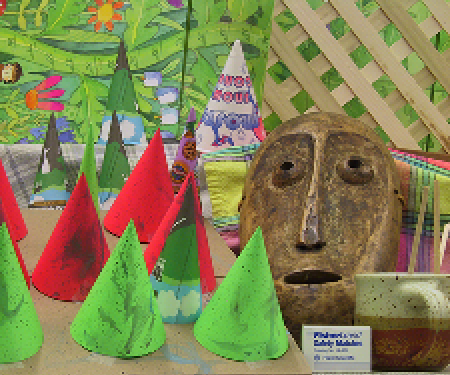

Input right image


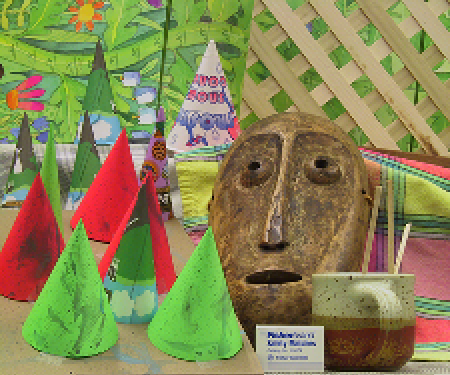

Left Disparity


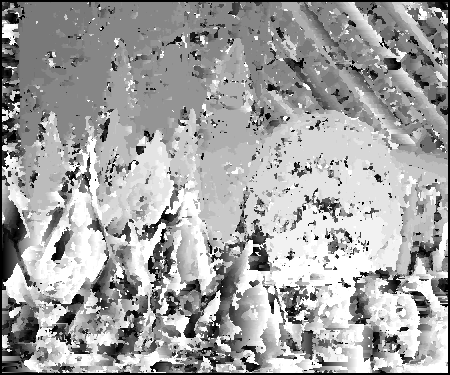

Right Disparity


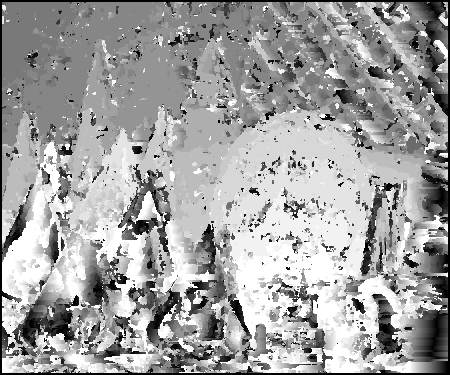

In [21]:
import numpy as np
import cv2


# Set the desired number of levels for multi-resolution here (level = 1 is the original image)
levels = 2


def getOriginalImages():
    # Change the images here to test
    left = cv2.imread('/content/drive/MyDrive/stereo/left2.png')
    right = cv2.imread('/content/drive/MyDrive/stereo/right2.png')

    originalLeft = left.copy()
    originalRight = right.copy()

    return originalLeft, originalRight


def resolution(image, levels):

    h, w, c = image.shape

    outputImage = image

    # Duplicating 1-pixel to the corresponding 4-pixels
    for i in range(0, h, 2**(levels-1)):
        for j in range(0, w, 2**(levels-1)):
            for k in range(0, 3, 1):
                outputImage[i:i+2**(levels-1), j:j+2**(levels-1), k] = image[i, j, k]

    return outputImage


def initImage():
    left, right = getOriginalImages()

    left = resolution(left, levels)
    right = resolution(right, levels)
    print('Input left image')
    cv2_imshow( left)
    print('Input right image')
    cv2_imshow(right)

    left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
    right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

    # Set the template size here
    templateSize = 5

    # Set the matching window here
    window = 80

    return left, right, templateSize, window


# Stereo matching using SSD
def ssd():

    # Calculate disparity maps of the left and right images
    left, right, templateSize, window = initImage()
    leftDisparity = np.abs(disparity_ssd(left, right, templateSize=templateSize, window=window, lambdaValue=0.0))
    rightDisparity = np.abs(disparity_ssd(right, left, templateSize=templateSize, window=window, lambdaValue=0.0))

    # Scale disparity maps
    leftDisparity = cv2.normalize(leftDisparity, leftDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    rightDisparity = cv2.normalize(rightDisparity, rightDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return leftDisparity, rightDisparity


# Stereo matching using SAD
def sad():

    # Calculate disparity maps of the left and right images
    left, right, templateSize, window = initImage()
    leftDisparity = np.abs(disparity_sad(left, right, templateSize=templateSize, window=window, lambdaValue=0.0))
    rightDisparity = np.abs(disparity_sad(right, left, templateSize=templateSize, window=window, lambdaValue=0.0))

    # Scale disparity maps
    leftDisparity = cv2.normalize(leftDisparity, leftDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    rightDisparity = cv2.normalize(rightDisparity, rightDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return leftDisparity, rightDisparity


# Stereo matching using normalized correlation
def ncc():

    # Calculate disparity maps of the left and right images
    left, right, templateSize, window = initImage()
    leftDisparity = np.abs(disparity_ncorr(left, right, templateSize=templateSize, window=window, lambdaValue=0.0))
    rightDisparity = np.abs(disparity_ncorr(right, left, templateSize=templateSize, window=window, lambdaValue=0.0))

    # Scale disparity maps
    leftDisparity = cv2.normalize(leftDisparity, leftDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,
                        dtype=cv2.CV_8U)
    rightDisparity = cv2.normalize(rightDisparity, rightDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,
                        dtype=cv2.CV_8U)

    return leftDisparity, rightDisparity




# Propogating disparity to the lower level of the pyramid and updating the disparities
def propogatemultiresolutionanalysis(left, right):
    h, w = left.shape

    for k in range(levels-1, 0, -1):
        outputLeft = left.copy()
        for i in range(0, h, 2 ** (k)):
            for j in range(0, w, 2 ** (k)):
                outputLeft[i:i + 2 ** (k), j:j + 2 ** (k)] = left[i, j]
        print('Propogated Left Disparity ' + str(k))
        cv2_imshow( outputLeft)

    for k in range(levels-1, 0, -1):
        outputRight = right.copy()
        for i in range(0, h, 2 ** (k)):
            for j in range(0, w, 2 ** (k)):
                outputRight[i:i + 2 ** (k), j:j + 2 ** (k)] = left[i, j]
        print('Propogated Right Disparity ' + str(k))
        cv2_imshow( outputRight)

    newLeft, newRight = getOriginalImages()
    newLeft = cv2.cvtColor(newLeft, cv2.COLOR_BGR2GRAY)
    newRight = cv2.cvtColor(newRight, cv2.COLOR_BGR2GRAY)
    newLeftDisparity = np.abs(disparity_ssd(newLeft, right, templateSize=7, window=100, lambdaValue=0.0))
    newRightDisparity = np.abs(disparity_ssd(newRight, left, templateSize=7, window=100, lambdaValue=0.0))

    # Scale disparity maps
    newLeftDisparity = cv2.normalize(newLeftDisparity, newLeftDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,
                                  dtype=cv2.CV_8U)
    newRightDisparity = cv2.normalize(newRightDisparity, newRightDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,
                                   dtype=cv2.CV_8U)

    updatedLeft = newLeftDisparity + outputLeft
    updatedRight = newRightDisparity + outputRight
    print('updatedleft')
    cv2_imshow( updatedLeft)
    print('updated right')
    cv2_imshow(updatedRight)
    return updatedLeft,updatedRight


def selectScore():
    score = input("Select a matching score: 1.SSD   2.SAD   3.NCC ")

    if score == '1':
        left, right = ssd()
        print('Left Disparity')
        cv2_imshow( left)
        print('right disparity')
        cv2_imshow( right)

        #updatedLeft,updatedRight=propogatemultiresolutionanalysis(left, right)
        return left,right
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    elif score == '2':
        left, right = sad()
        print('Left Disparity')
        cv2_imshow( left)
        print('Right Disparity')
        cv2_imshow( right)

        #updatedLeft,updatedRight =propogatemultiresolutionanalysis(left, right)
        return left,right
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    elif score == '3':
        left, right = ncc()
        print('Left Disparity')
        cv2_imshow( left)
        print('Right Disparity')
        cv2_imshow( right)

        #updatedLeft,updatedRight=propogatemultiresolutionanalysis(left, right)
        return left,right
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    else:
        print ("Select a valid matching score")


updatedLeftregionbased,updatedRightregionbased = selectScore()



Feature based disparity implementation with 3 level multiresolution analysis based on three different distances.

Select a matching score: 1.SSD   2.SAD   3.NCC 2
Input left image


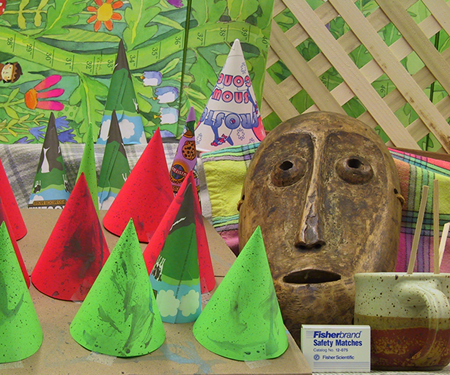

Input right image


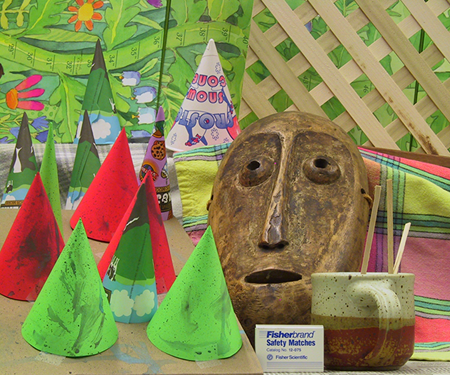

Finding Corners of the image
Finding Corners of the image
Corner Response Left Image


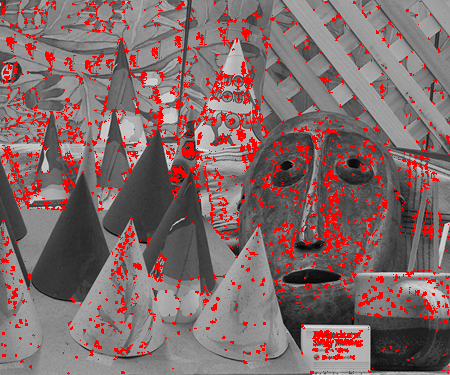

Corner Response Right Image


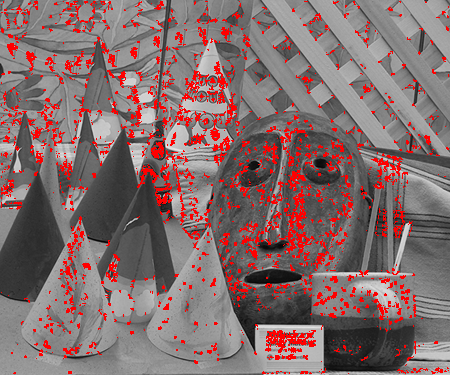

Left Disparity


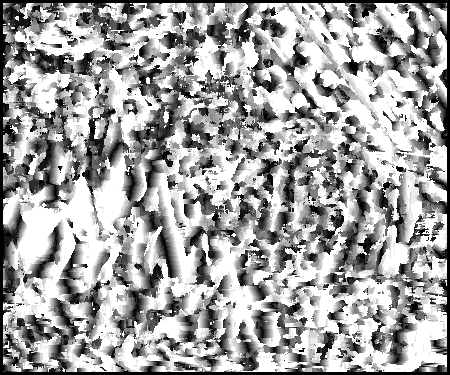

Right Disparity


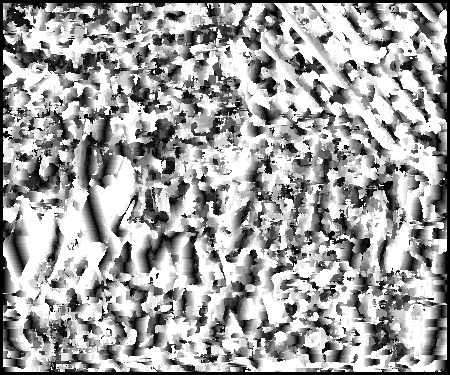

In [22]:
import cv2
import numpy as np



def findCorners(image, window_size, k, thresh):
    # Find x and y derivatives
    dy, dx = np.gradient(image)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = image.shape[0]
    width = image.shape[1]

    cornerList = []
    copiedImage = image.copy()
    outputImage = cv2.cvtColor(copiedImage, cv2.COLOR_GRAY2RGB)
    offset = window_size//2

    # Loop through the images and detect the corners
    print( "Finding Corners of the image")
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            # Calculating corner response using determinant and trace
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)

            # If corner response crosses threshold, point is marked
            if r > thresh:
                # print x, y, r
                cornerList.append([x, y, r])
                outputImage.itemset((y, x, 0), 0)
                outputImage.itemset((y, x, 1), 0)
                outputImage.itemset((y, x, 2), 255)
    return outputImage, cornerList


# Set the desired number of levels here (level = 1 is the original image)
levels = 3


def getOriginalImages():
    # Change the images here to test
    left = cv2.imread('/content/drive/MyDrive/stereo/left2.png')
    right = cv2.imread('/content/drive/MyDrive/stereo/right2.png')

    originalLeft = left.copy()
    originalRight = right.copy()

    return originalLeft, originalRight


def resolution(image, levels):
    if(levels < 1):
        print ("Enter valid number of levels")

    h, w, c = image.shape

    outputImage = image

    for i in range(0, h, 2**(levels-1)):
        for j in range(0, w, 2**(levels-1)):
            for k in range(0, 3, 1):
                outputImage[i:i+2**(levels-1), j:j+2**(levels-1), k] = image[i, j, k]

    return outputImage


def initImage():
    left,right = getOriginalImages()
    print('Input left image')
    cv2_imshow( left)
    print('Input right image')
    cv2_imshow( right)
    #left = resolution(left, levels)
    #right = resolution(right, levels)


    # Set the template size here
    templateSize = 7

    # Set the matching window here
    window = 30

    left = cv2.cvtColor(left, cv2.COLOR_RGB2GRAY)
    right = cv2.cvtColor(right, cv2.COLOR_RGB2GRAY)

    window_size = 3
    k = 0.15
    thresh = 100000

    finalLeft, cornerList = findCorners(left, int(window_size), float(k), int(thresh))
    finalRight, cornerList = findCorners(right, int(window_size), float(k), int(thresh))

    return finalLeft, finalRight, templateSize, window


# Stereo matching using SSD
def ssd():

    # Calculate disparity maps of the left and right images
    left, right, templateSize, window = initImage()
    print('Corner Response Left Image')
    cv2_imshow( left)
    print('Corner Response Right Image')
    cv2_imshow( right)
    left = cv2.cvtColor(left,cv2.COLOR_RGB2GRAY)
    right = cv2.cvtColor(right, cv2.COLOR_RGB2GRAY)
    leftDisparity = np.abs(disparity_ssd(left, right, templateSize=templateSize, window=window, lambdaValue=0.0))
    rightDisparity = np.abs(disparity_ssd(right, left, templateSize=templateSize, window=window, lambdaValue=0.0))
    # Scale disparity maps
    leftDisparity = cv2.normalize(leftDisparity, leftDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    rightDisparity = cv2.normalize(rightDisparity, rightDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return leftDisparity, rightDisparity


# Stereo matching using SAD
def sad():

    # Calculate disparity maps of the left and right images
    left, right, templateSize, window = initImage()
    print('Corner Response Left Image')
    cv2_imshow( left)
    print('Corner Response Right Image')
    cv2_imshow( right)
    left = cv2.cvtColor(left, cv2.COLOR_RGB2GRAY)
    right = cv2.cvtColor(right, cv2.COLOR_RGB2GRAY)
    leftDisparity = np.abs(disparity_sad(left, right, templateSize=templateSize, window=window, lambdaValue=0.0))
    rightDisparity = np.abs(disparity_sad(right, left, templateSize=templateSize, window=window, lambdaValue=0.0))
    # Scale disparity maps
    leftDisparity = cv2.normalize(leftDisparity, leftDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    rightDisparity = cv2.normalize(rightDisparity, rightDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return leftDisparity, rightDisparity


# Stereo matching using normalized correlation
def ncc():

    # Calculate disparity maps of the left and right images
    left, right, templateSize, window = initImage()
    print('Corner Response Left Image')
    cv2_imshow( left)
    print('Corner Response Right Image')
    cv2_imshow( right)
    left = cv2.cvtColor(left, cv2.COLOR_RGB2GRAY)
    right = cv2.cvtColor(right, cv2.COLOR_RGB2GRAY)
    leftDisparity = np.abs(disparity_ncorr(left, right, templateSize=templateSize, window=window, lambdaValue=0.0))
    rightDisparity = np.abs(disparity_ncorr(right, left, templateSize=templateSize, window=window, lambdaValue=0.0))
    # Scale disparity maps
    leftDisparity = cv2.normalize(leftDisparity, leftDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,
                        dtype=cv2.CV_8U)
    rightDisparity = cv2.normalize(rightDisparity, rightDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,
                        dtype=cv2.CV_8U)

    return leftDisparity, rightDisparity




# Propogating disparity to the lower level of the pyramid and updating the disparities
def propogatemultiresolutionanalysis(left, right):
    h, w = left.shape

    for k in range(levels-1, 0, -1):
        outputLeft = left.copy()
        for i in range(0, h, 2 ** (k)):
            for j in range(0, w, 2 ** (k)):
                outputLeft[i:i + 2 ** (k), j:j + 2 ** (k)] = left[i, j]
        print('Propogated Left Disparity ' + str(k))
        cv2_imshow( outputLeft)

    for k in range(levels-1, 0, -1):
        outputRight = right.copy()
        for i in range(0, h, 2 ** (k)):
            for j in range(0, w, 2 ** (k)):
                outputRight[i:i + 2 ** (k), j:j + 2 ** (k)] = left[i, j]
        print('Propogated Right Disparity ' + str(k))
        cv2_imshow( outputRight)

    newLeft, newRight = getOriginalImages()
    newLeft = cv2.cvtColor(newLeft, cv2.COLOR_BGR2GRAY)
    newRight = cv2.cvtColor(newRight, cv2.COLOR_BGR2GRAY)
    newLeftDisparity = np.abs(disparity_ssd(newLeft, right, templateSize=7, window=100, lambdaValue=0.0))
    newRightDisparity = np.abs(disparity_ssd(newRight, left, templateSize=7, window=100, lambdaValue=0.0))

    # Scale disparity maps
    newLeftDisparity = cv2.normalize(newLeftDisparity, newLeftDisparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,
                                     dtype=cv2.CV_8U)
    newRightDisparity = cv2.normalize(newRightDisparity, newRightDisparity, alpha=0, beta=255,
                                      norm_type=cv2.NORM_MINMAX,
                                      dtype=cv2.CV_8U)

    updatedLeft = newLeftDisparity + outputLeft
    updatedRight = newRightDisparity + outputRight
    print('Updated left')
    cv2_imshow( updatedLeft)
    print('Updated right')
    cv2_imshow( updatedRight)
    return updatedLeft,updatedRight


def selectScore():
    score = input("Select a matching score: 1.SSD   2.SAD   3.NCC ")

    if score == '1':
        left, right = ssd()
        print('Left Disparity')
        cv2_imshow( left)
        print('Right Disparity')
        cv2_imshow(right)
        #validity(left, right)
        #averaging(left,right)
        #updatedLeft,updatedRight=propogatemultiresolutionanalysis(left, right)
        return left,right
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()

    elif score == '2':
        left, right = sad()
        print('Left Disparity')
        cv2_imshow(left)
        print('Right Disparity')
        cv2_imshow( right)

        #updatedLeft,updatedRight=propogatemultiresolutionanalysis(left, right)
        return left,right
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()

    elif score == '3':
        left, right = ncc()
        print('Left Disparity')
        cv2_imshow( left)
        print('Right Disparity')
        cv2_imshow( right)

        updatedLeft,updatedRight=propogatemultiresolutionanalysis(left, right)
        return left,right
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()

    else:
        print ("Select a valid matching score")


updatedLeftfeaturebased,updatedRightfeaturebased=selectScore()

3)Validity checking :

validity checking for region based disparity maps
Validated Left Image


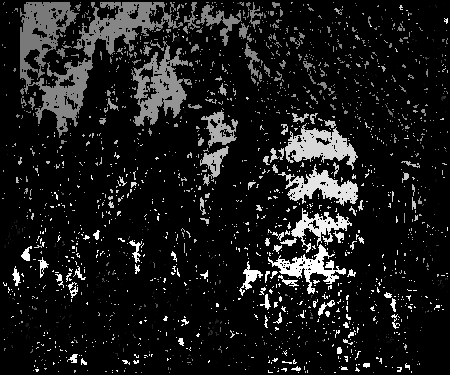

Validated right Image


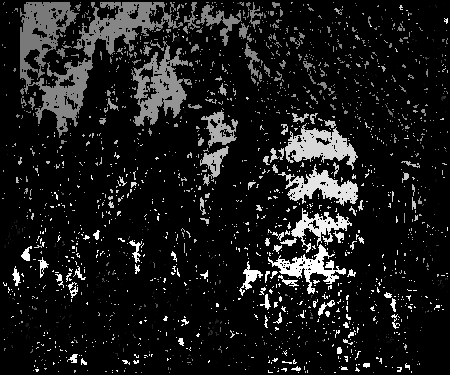

In [23]:
# Validity check of the two images
def validity(left, right):
    r1, c1 = left.shape
    r2, c2 = right.shape

    # Validate left image by calculating left - right image disparities
    for i in range(0, r1, 1):
        for j in range(0, c1, 1):
            if left[i,j] != right[i,j]:
                left[i,j] = 0

    # Validate left image by calculating right - left image disparities
    for i in range(0, r2, 1):
        for j in range(0, c2, 1):
            if right[i, j] != left[i, j]:
                right[i, j] = 0
    print('Validated Left Image')
    cv2_imshow( left)
    print('Validated right Image')
    cv2_imshow( right)
    return left,right
print('validity checking for region based disparity maps')
updatedLeftregionbased,updatedRightregionbased = validity(updatedLeftregionbased,updatedRightregionbased)

validity checking for feature based disparity maps
Validated Left Image


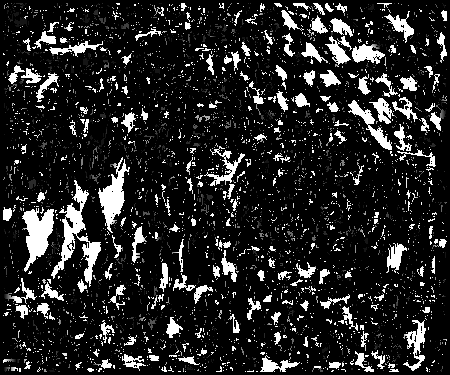

Validated right Image


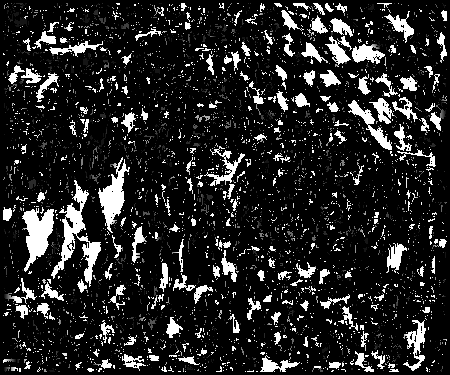

In [24]:
print('validity checking for feature based disparity maps')
updatedLeftfeaturebased,updatedRightfeaturebased=validity(updatedLeftfeaturebased,updatedRightfeaturebased)

4)Averaging performed to fill the gaps .

1)Region based averaging

Averaging for region based disparity maps
Averaged Left Image


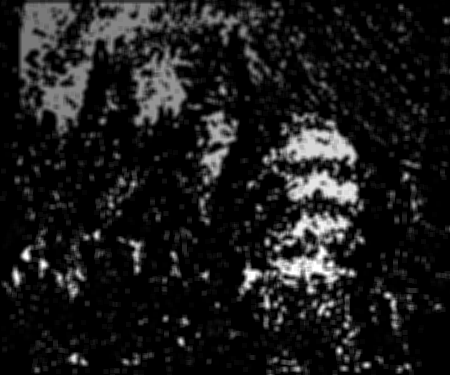

Averaged Right Image


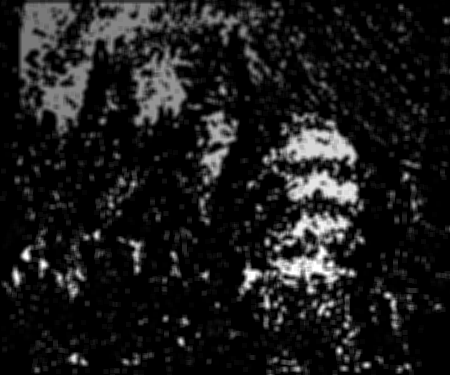

In [25]:
# Averaging is performed in the neighborhood to fill the gaps (zeroes)
def averaging(left, right):
    kernel = np.ones((5, 5), np.float32) / 25
    left = cv2.filter2D(left, -1, kernel)
    right = cv2.filter2D(right, -1, kernel)
    print('Averaged Left Image')
    cv2_imshow( left)
    print('Averaged Right Image')
    cv2_imshow(right)
    return left,right
print('Averaging for region based disparity maps')
updatedLeftregionbased,updatedRightregionbased=averaging(updatedLeftregionbased,updatedRightregionbased)

2)Feature based averaging

Averaging for feature based disparity maps
Averaged Left Image


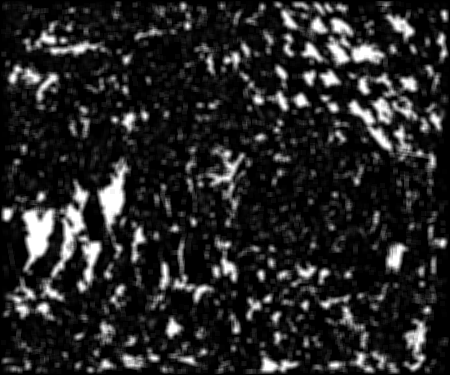

Averaged Right Image


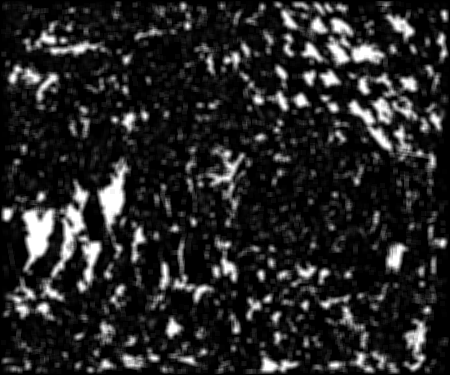

In [26]:
print('Averaging for feature based disparity maps')
updatedLeftfeaturebased,updatedRightfeaturebased=averaging(updatedLeftfeaturebased,updatedRightfeaturebased)